# Explore Tall's Puget Sound O2 Obs Datasets

Exploration of one of the Puget Sound dissolved O2 datasets that Tall obtained from
http://nwem.apl.washington.edu/erddap/

In [14]:
from pathlib import Path

import arrow
from matplotlib import pyplot as plt
import xarray

Paths to collection of obs datasets,
and to a specific dataset:

In [2]:
obs_dir = Path("/ocean/atall/MOAD/Obs/PugetSound/ERDDAP/")
obs_file = obs_dir / "L2_gridded_025_TW_20070101-20071231.nc"

Load and display the dataset so we can learn about its structure:

In [3]:
ds = xarray.open_dataset(obs_file)
ds

<xarray.Dataset>
Dimensions:                                           (cast_start_time: 2878,
                                                       sea_water_pressure: 141)
Coordinates:
  * cast_start_time                                   (cast_start_time) datetime64[ns] ...
  * sea_water_pressure                                (sea_water_pressure) float64 ...
Data variables:
    sea_water_temperature                             (cast_start_time, sea_water_pressure) float64 ...
    sea_water_practical_salinity                      (cast_start_time, sea_water_pressure) float64 ...
    sea_water_sigma_theta                             (cast_start_time, sea_water_pressure) float64 ...
    depth                                             (cast_start_time, sea_water_pressure) float64 ...
    mass_concentration_of_chlorophyll_a_in_sea_water  (cast_start_time, sea_water_pressure) float64 ...
    mole_concentration_of_nitrate_in_sea_water        (cast_start_time, sea_water_pressure) float64 ...
    mass_concentration_of_oxygen_in_sea_water         (cast_start_time, sea_water_pressure) float64 ...
Attributes: (12/30)
    author:                    Seth Travis
    buoy_designation:          ORCA1
    buoy_latitude:             47.375 degrees N
    buoy_longitude:            -123.00833333 degrees E
    buoy_name:                 Twanoh
    buoy_reference_number:     1
    ...                        ...
    license:                   The data may be used and redistributed for fre...
    sourceUrl:                 (local files)
    standard_name_vocabulary:  CF Standard Name Table v70
    summary:                   The Northwest Environmental Moorings program m...
    title:                     ORCA1 - Twanoh - L2 Pressure Gridded Data - 0....
    water_depth:               35 meters

`cast_start_time` is the time coordinate we have to work with.
How are the cast times organized?


In [4]:
ds.cast_start_time[:5]

<xarray.DataArray 'cast_start_time' (cast_start_time: 5)>
array(['2007-01-01T05:00:41.000000000', '2007-01-01T17:00:41.000000000',
       '2007-01-02T05:00:42.000000000', '2007-01-02T17:00:43.000000000',
       '2007-01-03T17:00:01.000000000'], dtype='datetime64[ns]')
Coordinates:
  * cast_start_time  (cast_start_time) datetime64[ns] 2007-01-01T05:00:41 ......
Attributes:
    actual_range:   [1.16762764e+09 1.19916364e+09]
    description:    Start time of cast, based on number of days since the def...
    ioos_category:  Time
    long_name:      cast start time
    standard_name:  time
    time_origin:    01-JAN-1970 00:00:00
    timezone:       UTC

It looks like a cast starts nominally every 12 hours at 05:00 and 17:00 UTC.
But the fact that there are 2878 values of `cast_start_time` suggests that the
frequency may be higher that twice daily during some parts of the year.

Now, let's look at the depths at which obs were collected during a specific cast:

In [5]:
ds.depth.sel(cast_start_time=ds.cast_start_time[0])

<xarray.DataArray 'depth' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  35.0
    colorBarMinimum:  0.0
    colorBarPalette:  TopographyDepth
    description:      Z-coordinate of observation in vertical distance below ...
    ioos_category:    Location
    long_name:        depth
    references:       UNESCO 1983 - Pressure to Depth Conversion
    standard_name:    depth
    units:            m

The array of depth values is accessible via the `data` attribute:

In [6]:
ds.depth.sel(cast_start_time=ds.cast_start_time[0]).data

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.73046154,  1.98438095,  2.23139355,
        2.48028889,  2.72643226,  2.94419444,  3.19525   ,  3.49983065,
        3.71809474,  3.96650476,  4.21412881,  4.43342857,  4.70998667,
        4.95365625,  5.23635714,  5.4557193 ,  5.70066129,  5.95226667,
        6.19671667,  6.44751481,  6.69403226,  6.9406    ,  7.18826154,
        7.43630526,  7.68355294,  7.93445517,  8.18206316,  8.42965556,
        8.67915172,  8.92515254,  9.1733931 ,  9.41888966,  9.66732143,
        9.91572258, 10.16325161, 10.41241639, 10.66163051, 10.92140923,
       11.15441481, 11.40429655, 11.64794909, 11.90027368, 12.14649231,
       12.39255294, 12.64414074, 12.89189677, 13.13601017, 13.38615862,
       13.63514483, 13.88452143, 14.131     , 14.38054   , 14.6259    ,
       14.87563077, 15.12191429, 15.3704    , 15.61833103, 15.86556429,
       16.11453962, 16.36102593, 16.61045455, 16.85954286, 17.10

Rather than messing around with indexing in the the `cast_start_time` data array,
we can let the `sel()` method find the nearest cast time to a NEMO model time.
The SalishSeaCast NEMO model hourly results are hour-averages centered on the half hour.
They are on UTC time as are the observations.
So, this is an easy way to match observations to model results time points:

In [7]:
depths = ds.depth.sel(cast_start_time="2007-01-01 05:30:00", method="nearest")
depths

<xarray.DataArray 'depth' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  35.0
    colorBarMinimum:  0.0
    colorBarPalette:  TopographyDepth
    description:      Z-coordinate of observation in vertical distance below ...
    ioos_category:    Location
    long_name:        depth
    references:       UNESCO 1983 - Pressure to Depth Conversion
    standard_name:    depth
    units:            m

The same technique works for the measured obs values:

In [22]:
sw_temps = ds.sea_water_temperature.sel(cast_start_time="2007-01-01 05:30:00", method="nearest")
sw_temps

<xarray.DataArray 'sea_water_temperature' (sea_water_pressure: 141)>
[141 values with dtype=float64]
Coordinates:
    cast_start_time     datetime64[ns] 2007-01-01T05:00:41
  * sea_water_pressure  (sea_water_pressure) float64 0.0 0.25 0.5 ... 34.75 35.0
Attributes:
    colorBarMaximum:  25.0
    colorBarMinimum:  5.0
    description:      In-situ temperature of water (T90 scale)
    ioos_category:    Temperature
    long_name:        Sea Water Temperature
    standard_name:    sea_water_temperature
    units:            degree_C

With that, we can do a profile plot on the obs water temperature:

Text(0.5, 0, 'Sea Water Temperature [degree_C]')

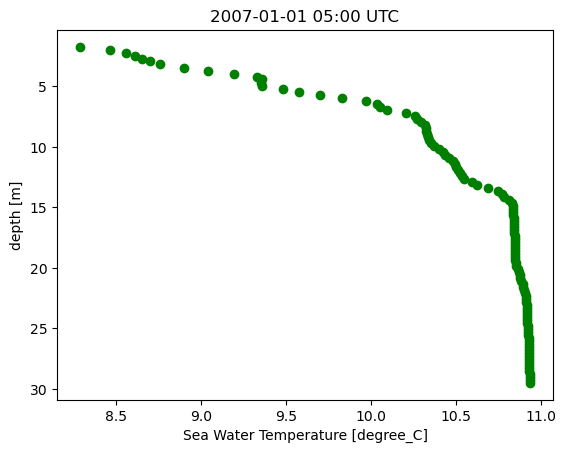

In [24]:
fig, ax = plt.subplots(1, 1)
ax.scatter(sw_temps, depths, color="g")
ax.invert_yaxis()
profile_time = arrow.get(str(sw_temp.cast_start_time.data))
ax.set_title(profile_time.format("YYYY-MM-DD HH:mm UTC"))
ax.set_ylabel(f"{depths.long_name} [{depths.units}]")
ax.set_xlabel(f"{sw_temps.long_name} [{sw_temps.units}]")